<a href="https://colab.research.google.com/github/fastdatascience/clinical_trial_risk/blob/fixes_nov_2022/train/ctgov/TrainSAPClassifier_05_NaiveBayes_fixed_vocab_smaller_doc_level_counts_one_per_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import spacy
import pandas as pd
import re
import os
import sys
import pickle as pkl
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import json

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.model_selection import cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_annotations = pd.read_csv("/content/drive/MyDrive/data/all_annotations.csv")


# Get data

In [60]:
stats_vocab = set("""0	pe
1	sap
2	tabulated
3	hazard
4	inferiority
5	categorical
6	meddra
7	residual
8	itt
9	continuous
10	summarised
11	variables
12	brv
13	variable
14	cox
16	laz
17	statistics
18	descriptive
19	regression
20	proportional
21	hazards
22	sided
23	deviation
26	percentage
27	calculated
28	analysed
29	censored
30	derived
31	coding
32	cumulative
34	soc
38	covariates
39	survival
40	deviations
41	pv
42	interim
43	class
44	hypothesis
45	sensitivity
46	power
47	ratio
48	summarized
49	median
50	measurements
51	model
52	endpoint
53	exploratory
54	statistical
55	plan
56	confidence
57	log
58	ipm
59	estimate
60	planned
62	classified
63	95%
64	solicited
65	iu
66	significance
67	adjusted
68	pq
69	randomisation
70	ci
71	values
72	differences
73	measures
74	signed
75	outcomes
76	assigned
77	analyses
78	overview
79	intervals
81	measurement
82	90%
83	versus
84	analysis
85	point
86	adherence
87	interval
88	secondary
89	value
90	groups
91	estimated
92	mean
93	relative
94	treat
95	frequency
96	outcome
97	detect
98	discharge
99	distribution
100	baseline
101	endpoints
102	dsmb
103	objectives
104	efficacy
105	method
106	negative
112	ae
113	rate
116	cd
119	parameters
120	maximum
123	crf
124	type
126	incidence
127	defined
128	function
129	50%
152	vs
155	database
156	effect
159	saes
169	one
173	two
178	observed
179	version
180	measure
182	three
202	design
265	sample
282	criteria
283	examination
284	evaluated
286	similar
312	control
325	sae
394	50
426	95
447	90
462	records
465	management
473	documents
478	access
490	55""".split("\n"))
stats_vocab = set([re.sub(r'^\d+\s+', '', w) for w in stats_vocab])

In [61]:
tok = RegexpTokenizer(r'[a-zA-Z]+')

In [81]:
with open("/content/drive/MyDrive/data/protocols.pkl.gz", "rb") as f:
    file_to_pages = pkl.load(f)

In [82]:
from nltk.tokenize import RegexpTokenizer

# Words and fractions and percentages
tok = RegexpTokenizer(r'\d+[\.,]\d+%?|[\w%]+|=|≤|≥|<|>')


def tokenise_text(page: str) -> list:
    """
    Tokenise the content of a single page
    :param page:
    """
    for word in tok.tokenize(page):
        yield word

def tokenise_text_and_lowercase(page: str) -> list:
    """
    Tokenise the content of a single page and return the lowercase of each token
    :param page:
    """
    for word in tok.tokenize(page):
        yield word.lower()

def tokenise_pages(pages):
    """
    Tokenises the lists of pages and returns a list of lists.
    This is a custom tokeniser as nunbers and percentages should not be split (e.g. 5.5%).

    :param pages: List of strings which each correspond to the content of a single page.
    :return: List of lists of tokens.
    """
    tokenised_pages = []

    for page in pages:
        tokens = []
        for word in tokenise_text(page):
            tokens.append(word)
        tokenised_pages.append(tokens)
    return tokenised_pages



def iterate_tokens(tokenised_pages):
    for page_no, tokens in enumerate(tokenised_pages):
        for token_no, token in enumerate(tokens):
            yield page_no, token_no, token

In [83]:
import operator
texts = []

for i in range(len(df_annotations)):
    file_name = df_annotations.file.iloc[i]
    
    pages= file_to_pages[file_name]

    text = ""
    for page in pages:
      tokens = set(tokenise_text_and_lowercase(page))
      text += " " + " ".join(tokens)


    texts.append(text)
df_annotations["text"] = texts

In [84]:
 del file_to_pages

In [85]:
df_annotations = df_annotations[~df_annotations.has_sap.isna()]

In [86]:
df_annotations["has_sap"].value_counts()

0    6150
1    5774
Name: has_sap, dtype: int64

In [87]:
df_train = df_annotations[df_annotations.train_val == "train"]
df_val = df_annotations[df_annotations.train_val == "val"]

In [88]:

# Specially engineered regex to include 95%, 95%ci, etc
vectoriser = CountVectorizer(lowercase=True, vocabulary=stats_vocab, min_df=5,
                             token_pattern=r'[59][05]%?(?:ci)?|[a-z][a-z]+')
transformer = TfidfTransformer()

nb = MultinomialNB()
model = make_pipeline(vectoriser, transformer, nb)

In [89]:
df_train_small = df_train.sample(100)

In [90]:
model.fit(df_train_small.text, df_train_small.has_sap)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5,
                                 token_pattern='[59][05]%?(?:ci)?|[a-z][a-z]+',
                                 vocabulary={'50', '50%', '55', '90', '90%',
                                             '95', '95%', 'access', 'adherence',
                                             'adjusted', 'ae', 'analysed',
                                             'analyses', 'analysis', 'assigned',
                                             'baseline', 'brv', 'calculated',
                                             'categorical', 'cd', 'censored',
                                             'ci', 'class', 'classified',
                                             'coding', 'confidence',
                                             'continuous', 'control',
                                             'covariates', 'cox', ...})),
                ('tfidftransformer', TfidfTransformer()),
                ('multinom

In [91]:
df_val["y_pred"] = model.predict(df_val.text)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [92]:
df_val["y_pred_proba"] = model.predict_proba(df_val.text)[:,1]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [93]:
sap_ground_truths = df_val.has_sap
pred_sap = df_val.y_pred

In [94]:
acc = accuracy_score(sap_ground_truths, pred_sap)
print (f"SAP accuracy {acc}")

SAP accuracy 0.7299539170506912


''

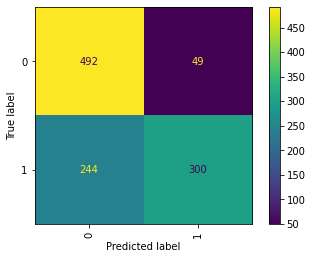

In [95]:
ConfusionMatrixDisplay.from_predictions(sap_ground_truths, pred_sap)
plt.xticks(rotation=90)
;

In [96]:
all_aucs = []
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(sap_ground_truths, pred_sap)
print (f"SAP ROC AUC {roc_auc}")

SAP ROC AUC 0.7304487876481461


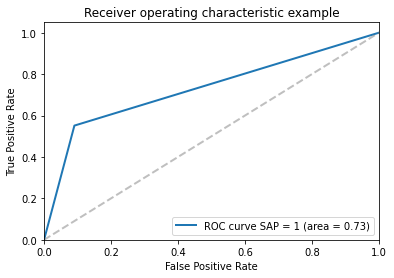

In [97]:
plt.figure()
lw = 2
    
for i in [1]:
    fpr, tpr, _ = roc_curve(sap_ground_truths, pred_sap)
    roc_auc = auc(fpr, tpr)
    plt.plot(
        fpr,
        tpr,
        # color="darkorange",
        lw=lw,
        label=f"ROC curve SAP = {i} (area = {roc_auc:0.2f})"
    )
    plt.plot([0, 1], [0, 1], color="gray", alpha=0.5, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [98]:
fake_document = " ".join(vectoriser.vocabulary_)
vectorised_document = vectoriser.transform([fake_document])
transformed_document = transformer.transform(vectorised_document)
probas = np.zeros((transformed_document.shape[1]))

for prediction_idx in [1]:
      print(f"Strongest predictors for class {prediction_idx}\n")
      for i in range(transformed_document.shape[1]):
          zeros = np.zeros(transformed_document.shape)
          zeros[0, i] = transformed_document[0, i]
          proba = nb.predict_log_proba(zeros)
          probas[i] = proba[0, prediction_idx]

      for ctr, j in enumerate(np.argsort(-probas)):
          for w, i in vectoriser.vocabulary_.items():
              if i == j:
                  print(f"{ctr}\t{w}")


Strongest predictors for class 1

0	pq
1	dsmb
2	vs
3	survival
4	regression
5	analysed
6	iu
7	cox
8	summarised
9	pe
10	cd
11	power
12	differences
13	pv
14	detect
15	residual
16	hypothesis
17	three
18	laz
19	brv
20	versus
21	estimate
22	incidence
23	plan
24	sensitivity
25	50%
26	outcomes
27	adjusted
28	cumulative
29	function
30	groups
31	control
32	two
33	significance
34	negative
35	coding
36	hazard
37	version
38	access
39	effect
40	median
41	outcome
42	similar
43	type
44	relative
45	frequency
46	derived
47	one
48	95
49	variable
50	censored
51	distribution
52	management
53	soc
54	calculated
55	90
56	50
57	randomisation
58	measures
59	proportional
60	estimated
61	value
62	sided
63	analysis
64	measure
65	database
66	model
67	statistical
68	design
69	categorical
70	deviation
71	secondary
72	rate
73	90%
74	continuous
75	overview
76	records
77	measurement
78	documents
79	objectives
80	discharge
81	confidence
82	observed
83	hazards
84	values
85	mean
86	signed
87	treat
88	variables
89	defined
9

In [99]:
import bz2
with bz2.open("sap_classifier_document_level.pkl.bz2", "wb") as f:
    pkl.dump(model, f)